# Keras tutorial
This tutorial is a modification from https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [1]:
import numpy as np
from keras.models import Sequential # linear stack of neural network layers
from keras.layers import Dense, Dropout, Activation, Flatten # layers to use
from keras.layers import Convolution2D, MaxPooling2D # CNN layers
from keras.utils import np_utils
from keras.utils import to_categorical
%load_ext autotime

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 867 ms


## Loading Data

Loading MURA images

In [3]:
import utils # importing from our utils functions

time: 3.19 s


In [4]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 1.88 s


We can look at the shape of the dataset:

In [5]:
x_train.shape
size = x_train.shape[1]

time: 840 µs


Visually inspect an image:

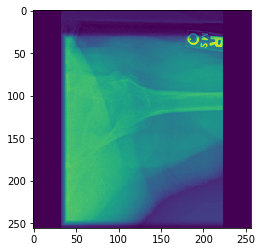

time: 178 ms


In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

## Data preparation

reshape the data to `size*size*1` (1 for channel)

In [7]:
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 1.17 ms


In [8]:
x_train.shape

(36808, 256, 256, 1)

time: 2.05 ms


Convert our data type to float32 and normalize our data values to the range [0, 1].

In [9]:
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

time: 4.04 s


even though we have a 0-1 target, it's easier if we frame it in terms of a 2-class classification task.

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

time: 1.44 ms


In [11]:
y_train.shape

(36808, 2)

time: 8.01 ms


## Define model architecture

In [17]:
# declare sequential model
with tf.device('/GPU:1'):
    model = Sequential() 
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(3, 3), activation='relu', input_shape=(size, size, 1)))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

time: 184 ms


## Compile model

We still need to define the loss and optimization method. Keras has a variety of [loss functions](https://keras.io/losses/) and out-of-the-box [optimizers](https://keras.io/optimizers/) to choose from. For this tutorial we'll use cross-entropy as loss function and [Adam](https://arxiv.org/abs/1412.6980) as our optimizer.

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

time: 68.7 ms


## Fitting the model

In [ ]:
model.fit(x_train, y_train, 
          batch_size=32, epochs=100, verbose=1)

We can check how loss and accuracy change over epochs

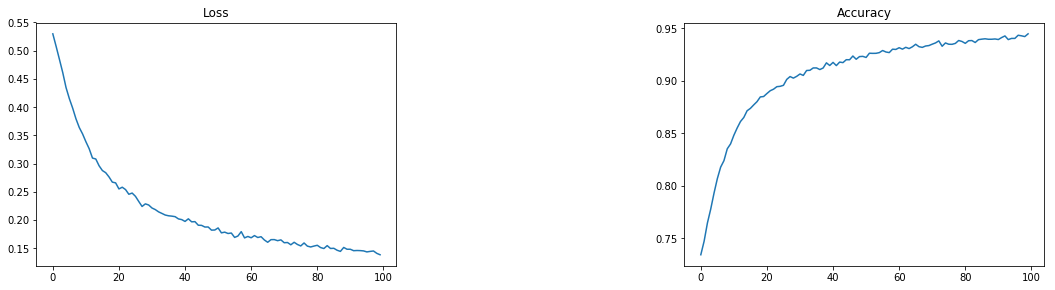

time: 302 ms


In [25]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

## Evaluating our model on the test set

### Loss and Accuracy

In [26]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 1.31 s


In [27]:
score

[1.1788865106158752, 0.6474820142579817]

time: 3.66 ms


In [28]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 1.2 s


In [29]:
# get actual digit labels
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat, axis=1)

time: 2.45 ms


### Cohen's Kappa

In [33]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 4.34 ms


In [34]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.39 ms


In [35]:
kappa

0.2875245474479849

time: 3.95 ms
